In [9]:
import pandas as pd

# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

In [10]:
df = pd.read_csv('../data/synthetic_compute_spend.csv')
df.head(5)

,business_unit,team,env,one_month_avg,six_month_avg,ec2_percentage,fargate_percentage,lambda_percentage,utilization_rate,deployment_frequency,seasonality,one_month_cv,six_month_cv,actual_compute_spend
0,r&d,credit,dev,79198.910935,93740.482814,12.597932,52.886931,27.447453,97.704696,high,high,0.026532,0.007770,148002.388651
1,infrastructure,credit,dev,96025.020234,80529.238336,15.646884,28.200641,8.212892,88.758046,medium,medium,0.019080,0.046369,132627.627250
2,r&d,ops,test,36234.909406,43096.520964,57.064379,43.021597,5.653959,90.181757,medium,high,0.175329,0.032533,98034.920370
3,r&d,research,dev,65243.997194,37829.868698,58.242699,54.655612,22.208269,76.580037,very high,medium,0.087324,0.132608,84746.110658
4,infrastructure,debit,staging,98371.737203,73817.304604,33.902858,51.773622,20.103266,59.339040,very high,medium,0.041143,0.052347,109308.378705


In [11]:
df['actual_compute_spend'].mean()

102981.84002650956

In [12]:
# Define the features and target
X = df.drop('actual_compute_spend', axis=1)
y = df['actual_compute_spend']

# Define categorical and numeric features
categorical_features = ['business_unit', 'team', 'env', 'deployment_frequency', 'seasonality']
numeric_features = ['one_month_avg', 'six_month_avg', 'ec2_percentage', 'fargate_percentage', 'lambda_percentage', 'utilization_rate', 'one_month_cv', 'six_month_cv']

# Preprocessor for handling categorical and numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create a pipeline with XGBoost
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 11060872.323436493
R^2 Score: 0.9839642739742567


In [13]:
df_sample = pd.read_csv('../data/sample_infrastructure_data.csv')

X_sample = df_sample.drop('actual_compute_spend', axis=1)

# Make predictions using the trained model
y_pred_sample = model.predict(X_sample)

# Display predictions
predictions = pd.DataFrame({
    'Actual Compute Spend': df_sample['actual_compute_spend'],
    'Predicted Compute Spend': y_pred_sample
})

print(predictions)


   Actual Compute Spend  Predicted Compute Spend
0                 40000             87731.695312
1                 41000             90148.890625
2                270000            132238.046875
3                200000            130687.617188
4                210000            132551.312500
5                 60000            115568.148438
6                 70000            130807.140625


In [14]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)


                                Feature  Importance
1                    num__six_month_avg    0.881625
5                 num__utilization_rate    0.078688
21        cat__deployment_frequency_low    0.006324
16                         cat__env_dev    0.003788
10               cat__business_unit_r&d    0.002309
11                     cat__team_credit    0.002287
17                        cat__env_prod    0.002005
24                cat__seasonality_high    0.001964
15                   cat__team_research    0.001517
22     cat__deployment_frequency_medium    0.001488
7                     num__six_month_cv    0.001445
20       cat__deployment_frequency_high    0.001430
19                        cat__env_test    0.001416
13                       cat__team_main    0.001370
2                   num__ec2_percentage    0.001368
12                      cat__team_debit    0.001242
4                num__lambda_percentage    0.001222
3               num__fargate_percentage    0.001124
26          

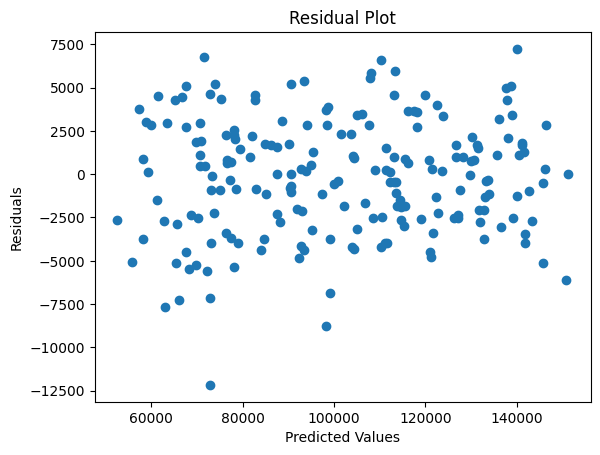

In [15]:
import matplotlib.pyplot as plt
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [16]:
# Access the OneHotEncoder within the pipeline's ColumnTransformer
encoder = model.named_steps['preprocessor'].named_transformers_['cat']

# Get the categories learned by the OneHotEncoder
categories = encoder.categories_

# Print the categories for each categorical feature
for feature, cats in zip(categorical_features, categories):
    print(f"Feature: {feature}")
    print(f"Categories: {cats}")
    print("\n")


Feature: business_unit
Categories: ['application' 'infrastructure' 'r&d']


Feature: team
Categories: ['credit' 'debit' 'main' 'ops' 'research']


Feature: env
Categories: ['dev' 'prod' 'staging' 'test']


Feature: deployment_frequency
Categories: ['high' 'low' 'medium' 'very high']


Feature: seasonality
Categories: ['high' 'low' 'medium']


